# Yearbook of International Organizations Analysis

This notebook analyzes the dataset scraped from the Yearbook of International Organizations (YBIO).

**Dataset:** `data/organizations_final.csv`

**Author:** Diwas Puri (diwas.puri@duke.edu), Duke University


In [34]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# plotting code here
warnings.filterwarnings("default", category=FutureWarning)


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Load data
df = pd.read_csv('../data/organizations_clean.csv')

# Display basic info
print(f"Total Organizations: {len(df):,}")
print(f"Columns: {list(df.columns)}")
display(df.head())

Total Organizations: 78,865
Columns: ['Name', 'Acronym', 'Founded', 'City', 'Country', 'Type I', 'Type II', 'UID']


,Name,Acronym,Founded,City,Country,Type I,Type II,UID
0,Federation of International Dance Festivals,FIDAF,2012.0,Chungnam,Korea Rep,B,NaN,XJ9650
1,Federation of International Geo-Engineering So...,FedIGS,2007.0,NaN,NaN,B,y,AA0037
2,FIDI Global Alliance,NaN,1950.0,Zaventem,Belgium,B,NaN,XB0947
3,Food and Agriculture Organization of the Unite...,FAO,1945.0,Rome,Italy,B,g,XB0971
4,Gender and Water Alliance,GWA,2000.0,Dieren,Netherlands,B,NaN,XM0973


## 1. Data Cleaning & Preprocessing

In [35]:
# Missing counts and percentages
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_pct': missing_pct.round(2)
}).sort_values('missing_pct', ascending=False)

print("Missing Values per Column")
print(missing_summary)

# Top 10 columns with most missing values
print("\nTop 10 columns by missing percent")
print(missing_summary.head(10))


Missing Values per Column
         missing_count  missing_pct
City             31526        39.97
Country          31520        39.97
Acronym          29848        37.85
Type II          26978        34.21
Founded          23718        30.07
Name                 0         0.00
Type I               0         0.00
UID                  0         0.00

Top 10 columns by missing percent
         missing_count  missing_pct
City             31526        39.97
Country          31520        39.97
Acronym          29848        37.85
Type II          26978        34.21
Founded          23718        30.07
Name                 0         0.00
Type I               0         0.00
UID                  0         0.00


## 2. Geographic Analysis
Where are these organizations headquartered?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33188\4134736729.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_countries.index, x=top_countries.values, palette='viridis')


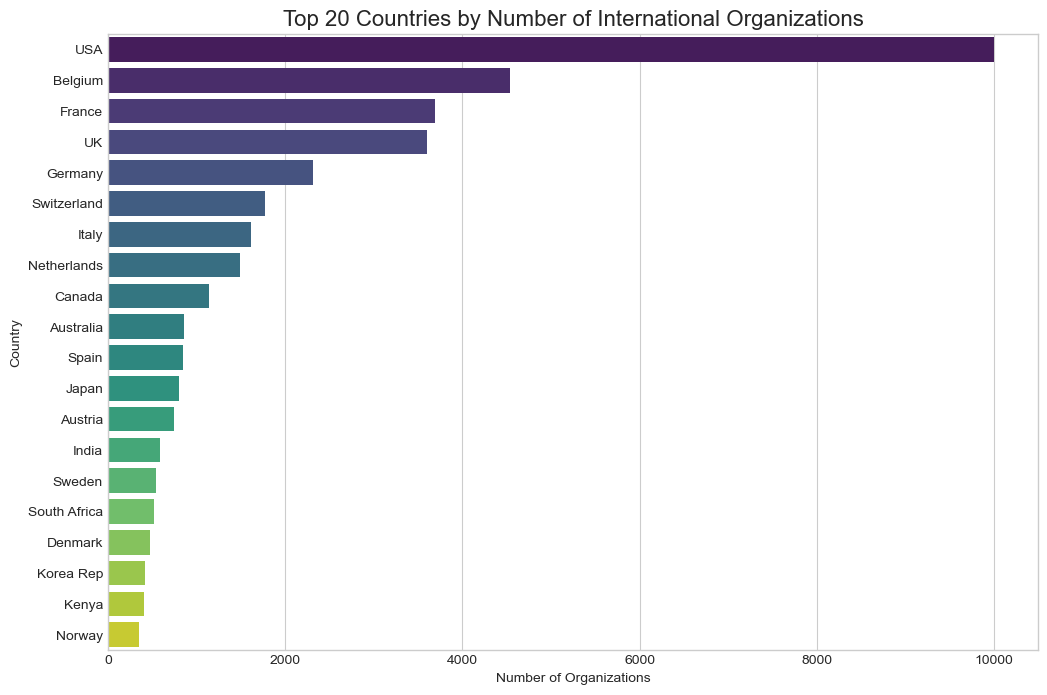

In [36]:
# Top 20 Countries
top_countries = df['Country'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_countries.index, x=top_countries.values, palette='viridis')
plt.title('Top 20 Countries by Number of International Organizations', fontsize=16)
plt.xlabel('Number of Organizations')
plt.ylabel('Country')
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33188\3005656390.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_cities.index, x=top_cities.values, palette='magma')


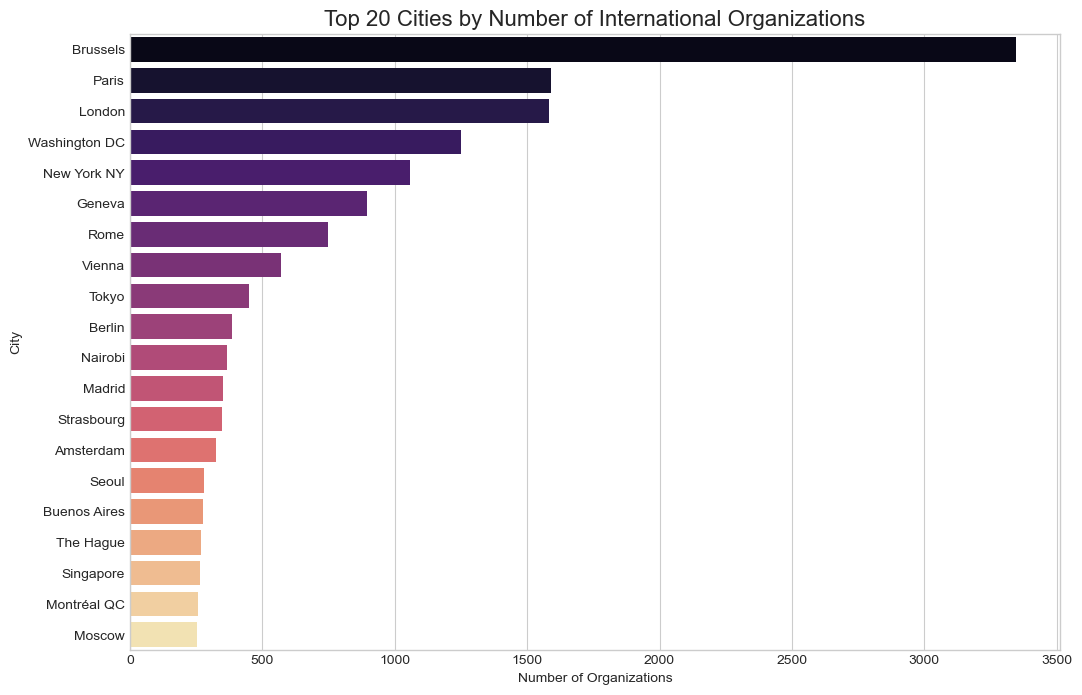

In [37]:
# Top 20 Cities
top_cities = df['City'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_cities.index, x=top_cities.values, palette='magma')
plt.title('Top 20 Cities by Number of International Organizations', fontsize=16)
plt.xlabel('Number of Organizations')
plt.ylabel('City')
plt.show()

## 3. Temporal Analysis
When were these organizations established?

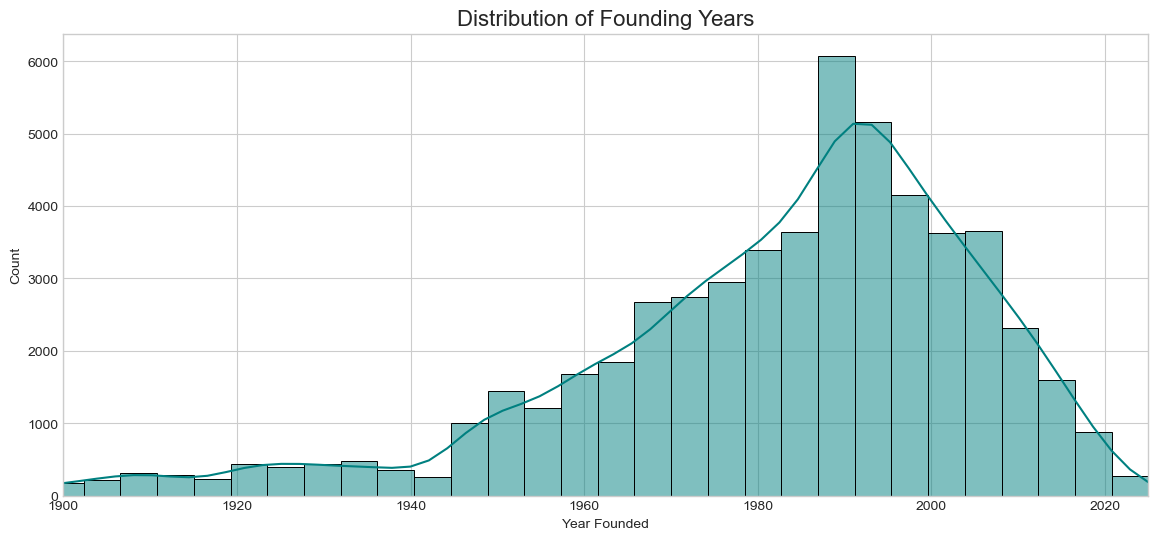

In [38]:

# Ensure valid_years_df exists
if 'valid_years_df' not in locals():
    if 'Founded_Year' not in df.columns:
        df['Founded_Year'] = pd.to_numeric(df['Founded'], errors='coerce')
    valid_years_df = df[(df['Founded_Year'] > 1600) & (df['Founded_Year'] <= 2025)]

plt.figure(figsize=(14, 6))
sns.histplot(data=valid_years_df, x='Founded_Year', bins=100, kde=True, color='teal')
plt.title('Distribution of Founding Years', fontsize=16)
plt.xlabel('Year Founded')
plt.ylabel('Count')
plt.xlim(1900, 2025)
plt.show()

## 4. Organization Types
Analyzing Type I and Type II classifications.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33188\2855982388.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type1_counts.values, y=type1_counts.index, ax=axes[0], palette='Blues_r')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33188\2855982388.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type2_counts.values, y=type2_counts.index, ax=axes[1], palette='Greens_r')


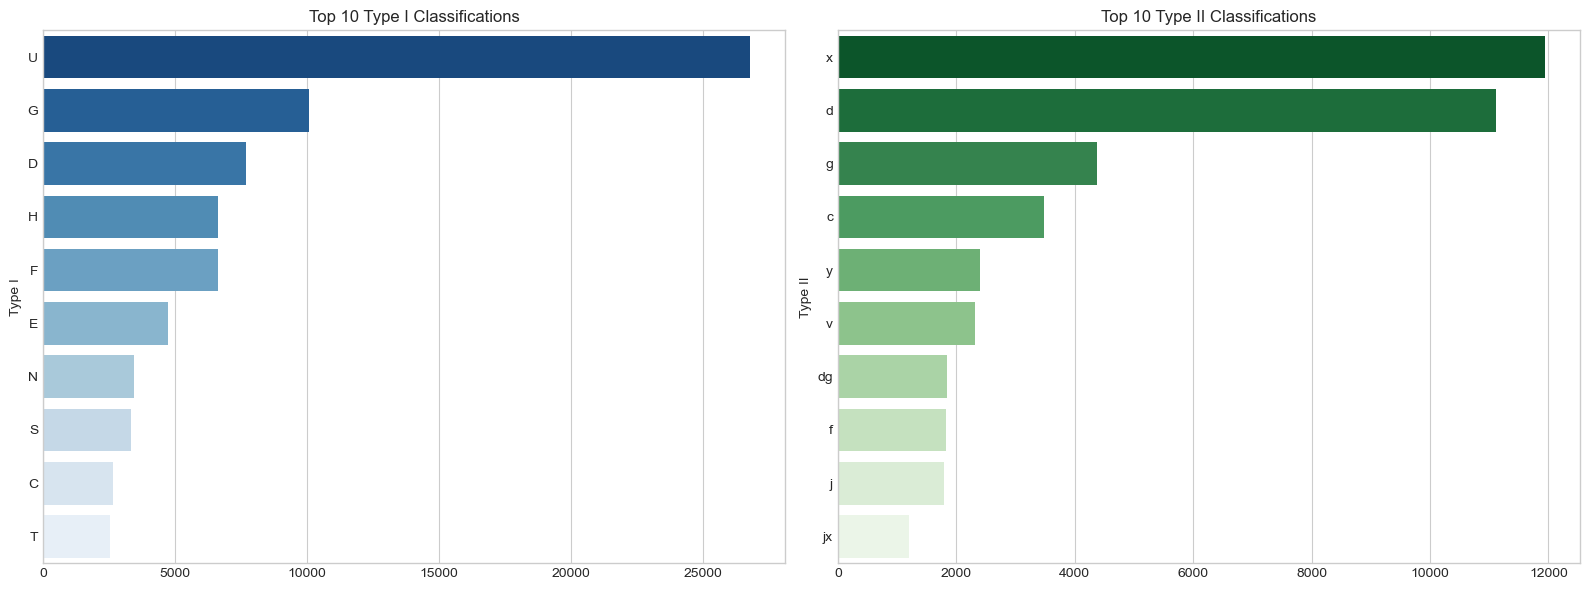

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Type I
type1_counts = df['Type I'].value_counts().head(10)
sns.barplot(x=type1_counts.values, y=type1_counts.index, ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 10 Type I Classifications')

# Type II
type2_counts = df['Type II'].value_counts().head(10)
sns.barplot(x=type2_counts.values, y=type2_counts.index, ax=axes[1], palette='Greens_r')
axes[1].set_title('Top 10 Type II Classifications')

plt.tight_layout()
plt.show()

## 5. Word Cloud of Names

In [ ]:
from wordcloud import WordCloud

# Combine all names
text = ' '.join(df['Name'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Organization Names', fontsize=20)
plt.show()